## Preprocessing

### Load embeddings

In [1]:
import codecs
import numpy as np
from numpy import linalg as LA
import string
import json
from tqdm import tqdm
import operator
import random
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3
from cycler import cycler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

# Function to load word embeddings from a file
def load_embeddings_from_np(filename):
    print('Loading...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]

    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i

# Function to normalize word vectors
def normalize(wv):
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv

# Function to load and normalize word embeddings
def load_and_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse
    wv[space] = wv_muse
    w2i[space] = w2i_muse

In [2]:
# Load and normalize word embeddings for 'bef' and 'aft'
vocab = {}
wv = {}
w2i = {}

load_and_normalize('bef', '/Users/jaehyunkim/Desktop/gender_bias_lipstick-master/data/embeddings/orig_w2v', vocab, wv, w2i)
load_and_normalize('aft', '/Users/jaehyunkim/Desktop/gender_bias_lipstick-master/data/embeddings/hard_debiased_w2v', vocab, wv, w2i)

Loading...
Loading...


In [3]:
def similar_words(word, space, threshold=0.9):
    idx = w2i[space][word]
    vec = wv[space][idx, :]
    
    # Compute cosine similarity between the word and all words in the space
    sim = wv[space].dot(vec)
    
    # Find words with similarity above the threshold
    similar_words_list = [vocab[space][i] for i, s in enumerate(sim) if s > threshold]
    
    return similar_words_list

In [4]:
# Function to compute bias by cosine similarity
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))


### Restrict vocabulary

In [5]:
# Function to check if a word has punctuation
def has_punct(w):
    if any([c in string.punctuation for c in w]):
        return True
    return False

# Function to check if a word has digits
def has_digit(w):
    if any([c in '0123456789' for c in w]):
        return True
    return False

# Function to limit vocabulary based on certain criteria
def limit_vocab(space, exclude=None):
    vocab_limited = []
    for w in tqdm(vocab[space][:50000]):
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)

    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))

    print("Size of vocabulary:", len(vocab_limited))

    wv_limited = np.zeros((len(vocab_limited), 300))
    for i, w in enumerate(vocab_limited):
        wv_limited[i, :] = wv[space][w2i[space][w], :]

    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}

    return vocab_limited, wv_limited, w2i_limited

In [6]:
# Load gender-specific word lists and definitional/equalize pairs
with codecs.open('/Users/jaehyunkim/Desktop/gender_bias_lipstick-master/data/lists/gender_specific_full.json') as f:
    gender_specific = json.load(f)
with codecs.open('/Users/jaehyunkim/Desktop/gender_bias_lipstick-master/data/lists/definitional_pairs.json') as f:
    definitional_pairs = json.load(f)
with codecs.open('/Users/jaehyunkim/Desktop/gender_bias_lipstick-master/data/lists/equalize_pairs.json') as f:
    equalize_pairs = json.load(f)

exclude_words = []
for pair in definitional_pairs + equalize_pairs:
    exclude_words.append(pair[0])
    exclude_words.append(pair[1])

exclude_words = list(set(exclude_words).union(set(gender_specific)))

# Create spaces of limited vocabulary
vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude=exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude=exclude_words)

assert(vocab['limit_aft'] == vocab['limit_bef'])


100%|██████████| 50000/50000 [00:00<00:00, 1756423.42it/s]


Size of vocabulary: 26189


100%|██████████| 50000/50000 [00:00<00:00, 1872106.12it/s]


Size of vocabulary: 26189


### Compute bias-by-projection

In [7]:
# Function to compute bias by cosine similarity
def compute_bias_by_cosine_similarity(space_to_tag, full_space):
    d = {}
    for w in tqdm(vocab[space_to_tag]):
        vec_w = wv[space_to_tag][w2i[space_to_tag][w], :]
        vec_he = wv[full_space][w2i[full_space]['he'], :]
        vec_she = wv[full_space][w2i[full_space]['she'], :]

        # Calculate cosine similarity using NumPy
        male_similarity = 1 - np.dot(vec_w, vec_he) / (LA.norm(vec_w) * LA.norm(vec_he))
        female_similarity = 1 - np.dot(vec_w, vec_she) / (LA.norm(vec_w) * LA.norm(vec_she))

        d[w] = male_similarity - female_similarity
    return d

# Compute bias by cosine similarity before and after debiasing
gender_bias_bef = compute_bias_by_cosine_similarity('limit_bef', 'bef')
gender_bias_aft = compute_bias_by_cosine_similarity('limit_aft', 'aft')

100%|██████████| 26189/26189 [00:01<00:00, 17286.71it/s]


In [8]:
# Function to report average bias of the vocabulary (absolute value)
def report_bias(gender_bias):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias / len(gender_bias))

report_bias(gender_bias_bef)
report_bias(gender_bias_aft)

0.04607731006352767
2.6279822242175067e-09


## Experiments

### Coreelation between bias-by-projection and bias-by-neighbors

In [9]:
# Function to get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)
def bias_by_neighbors(space, threshold=0.2, neighbours_num=100):
    tuples = []
    for w in tqdm(vocab[space]):
        similar_words_list = similar_words(w, space, threshold=threshold)  # Use the threshold parameter
        m = 0
        f = 0
        for t in similar_words_list:
            if gender_bias_bef[t] > 0:
                m += 1
            else:
                f += 1
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))
    return tuples

tuples_bef = bias_by_neighbors('limit_bef', threshold=0.2)
tuples_aft = bias_by_neighbors('limit_aft', threshold=0.2)


100%|██████████| 26189/26189 [03:25<00:00, 127.53it/s]


In [14]:
import scipy.stats

def pearson(a, b):
    return scipy.stats.pearsonr(a, b)[0]  # Use [0] to get the correlation coefficient

def compute_corr(tuples, i1, i2):
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a) == len(b))    
    correlation = pearson(a, b)
    print("Correlation:", correlation)

compute_corr(tuples_bef, 1, 3)
compute_corr(tuples_aft, 1, 3)

Correlation: 0.5241735753545016
Correlation: 0.4294894216598517


### Clustering Experiment - Visualize clusters of most biased words

In [11]:
# Function to visualize word vectors
def visualize(vectors, words, labels, ax, title, random_state, num_clusters=2):
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x, l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker='.', c='c')
            else:
                ax.scatter(x[0], x[1], marker='x', c='darkviolet')
    else:
        ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)
    ax.text(.01, .9, title, transform=ax.transAxes, fontsize=18)

# Function to extract word vectors
def extract_vectors(words, space1='limit_bef', space2='limit_aft'):
    size = len(words) // 2
    X_bef = [wv[space1][w2i[space1][x], :] for x in words]
    X_aft = [wv[space2][w2i[space2][x], :] for x in words]
    return X_bef, X_aft

# Function to cluster and visualize word vectors
def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, num=2):
    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    y_pred_bef = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_pred_bef, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1, item2) in zip(y_true, y_pred_bef)]
    print('Precision bef', sum(correct) / float(len(correct)))
    y_pred_aft = KMeans(n_clusters=num, random_state=random_state).fit_predict(X_aft)
    visualize(X_aft, words, y_pred_aft, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1, item2) in zip(y_true, y_pred_aft)]
    print('Precision aft', sum(correct) / float(len(correct)))
    fig.show()


/Users/jaehyunkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Precision bef 0.999


/Users/jaehyunkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Precision aft 0.915


/var/folders/yv/qjxr_fdj60l8jrbwjb5jnj2w0000gn/T/ipykernel_1791/341117249.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


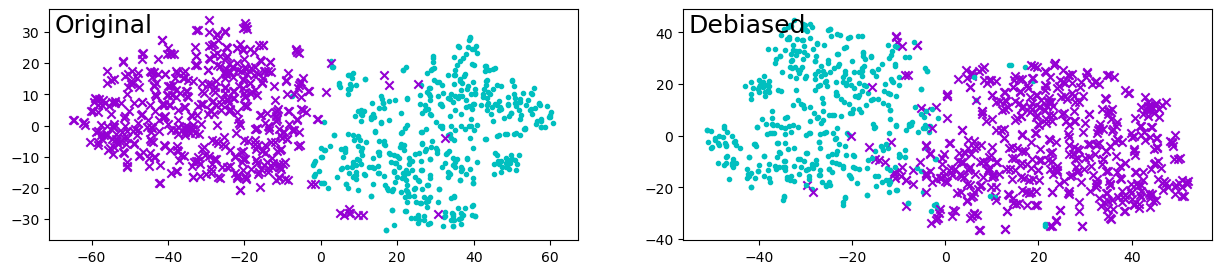

In [12]:
# Extract most biased words
random_state = 1
size = 500
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]

X_bef, X_aft = extract_vectors(male + female)
X_bef = np.array(X_bef)  # Convert to NumPy array
X_aft = np.array(X_aft)  # Convert to NumPy array
y_true = [1] * size + [0] * size
cluster_and_visualize(male + female, X_bef, X_aft, random_state, y_true)


In [13]:
# Function to train and predict using SVM classifier
def train_and_predict(space_train, space_test):
    X_train = [wv[space_train][w2i[space_train][w], :] for w in males[:size_train] + females[:size_train]]
    Y_train = [1] * size_train + [0] * size_train
    X_test = [wv[space_test][w2i[space_test][w], :] for w in males[size_train:] + females[size_train:]]
    Y_test = [1] * size_test + [0] * size_test

    clf = svm.SVC()
    clf.fit(X_train, Y_train)

    print('Train with', space_train)
    print('Test with', space_test)

    preds = clf.predict(X_test)

    accuracy = [1 if y == z else 0 for y, z in zip(preds, Y_test)]
    print('Accuracy:', float(sum(accuracy)) / len(accuracy))

# Extract most biased words for classification
size_train = 500
size_test = 2000
size = size_train + size_test
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
males = [item[0] for item in sorted_g[-size:]]
for f in females:
    assert(gender_bias_bef[f] < 0)
for m in males:
    assert(gender_bias_bef[m] > 0)
random.seed(10)
random.shuffle(females)
random.shuffle(males)

# Classification before debiasing
train_and_predict('bef', 'bef')

# Classification after debiasing
train_and_predict('aft', 'aft')

Train with bef
Test with bef
Accuracy: 1.0
Train with aft
Test with aft
Accuracy: 0.93675
